In [1]:
import torch
import numpy as np
import random
from IPython import display
from matplotlib import pyplot as plt
from torch import nn
import torch.utils.data as Data
import torch.optim as optim
from torch.nn import init
import torchvision
import torchvision.transforms as transforms
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"  #防止jupyter崩溃

In [2]:
#下载MNIST手写数据集
mnist_train = torchvision.datasets.MNIST(root='./Datasets/MNIST', train=True,
download=True, transform=transforms.ToTensor())
mnist_test = torchvision.datasets.MNIST(root='./Datasets/MNIST', train=False,
download=True, transform=transforms.ToTensor())
#读取数据
batch_size = 32
train_iter = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True,
num_workers=0)
test_iter = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False,
num_workers=0)

E:\Anaconda\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
#实现FlattenLayer层
class FlattenLayer(torch.nn.Module):
    def __init__(self):
         super(FlattenLayer, self).__init__()
    def forward(self, x):
        return x.view(x.shape[0],-1)

In [4]:
#模型定义和参数初始化
num_inputs,num_hiddens,num_outputs = 784,256,10
net = nn.Sequential(
        FlattenLayer(),
        nn.Linear(num_inputs,num_hiddens),
        nn.ReLU(),
        nn.Linear(num_hiddens,num_outputs),
        )

for params in net.parameters():
    init.normal_(params,mean=0,std=0.01)

In [5]:
#训练次数和学习率
num_epochs = 50
lr = 0.01
#定义交叉熵损失函数
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(),lr)

In [6]:
#测试集loss
def evaluate_loss(data_iter,net):
    acc_sum,loss_sum,n = 0.0,0.0,0
    for X,y in data_iter:
        y_hat = net(X)
        acc_sum += (y_hat.argmax(dim=1)==y).sum().item()
        l = loss(y_hat,y) # l是有关小批量X和y的损失
        loss_sum += l.sum().item()*y.shape[0]
        n+=y.shape[0]
    return acc_sum/n,loss_sum/n

In [7]:
#定义模型训练函数
def train(net,train_iter,test_iter,loss,num_epochs,batch_size,params=None,lr=None,optimizer=None):
    train_ls = []
    test_ls = []
    for epoch in range(num_epochs): # 训练模型一共需要num_epochs个迭代周期
        train_l_sum, train_acc_num,n = 0.0,0.0,0
        # 在每一个迭代周期中，会使用训练数据集中所有样本一次
        for X, y in train_iter: # x和y分别是小批量样本的特征和标签
            y_hat = net(X)
            l = loss(y_hat, y).sum() # l是有关小批量X和y的损失
            #梯度清零
            if optimizer is not None:
                optimizer.zero_grad()
            elif params is not None and params[0].grad is not None:
                for param in params:
                    param.grad.data.zero_()
            l.backward() # 小批量的损失对模型参数求梯度
            if optimizer is None:
                SGD(params,lr)
            else:
                optimizer.step()
            #计算每个epoch的loss
            train_l_sum += l.item()*y.shape[0]
            #计算训练样本的准确率
            train_acc_num += (y_hat.argmax(dim=1)==y).sum().item()
            #每一个epoch的所有样本数
            n+= y.shape[0]
        train_ls.append(train_l_sum/n)
        test_acc,test_l = evaluate_loss(test_iter,net)
        test_ls.append(test_l)
        print('epoch %d, train_loss %.6f,test_loss %f,train_acc %.6f,test_acc %.6f'%(epoch+1, train_ls[epoch],test_ls[epoch],train_acc_num/n,test_acc))
    return train_ls,test_ls

In [8]:
train_loss,test_loss = train(net,train_iter,test_iter,loss,num_epochs,batch_size,net.parameters,lr,optimizer)

epoch 1, train_loss 1.169667,test_loss 0.478044,train_acc 0.721500,test_acc 0.874600
epoch 2, train_loss 0.414722,test_loss 0.352032,train_acc 0.886917,test_acc 0.900000
epoch 3, train_loss 0.341161,test_loss 0.305744,train_acc 0.903850,test_acc 0.913400
epoch 4, train_loss 0.307177,test_loss 0.279704,train_acc 0.912633,test_acc 0.920200
epoch 5, train_loss 0.282806,test_loss 0.261243,train_acc 0.918933,test_acc 0.927100
epoch 6, train_loss 0.262820,test_loss 0.243037,train_acc 0.924933,test_acc 0.931400
epoch 7, train_loss 0.245316,test_loss 0.230804,train_acc 0.930150,test_acc 0.935300
epoch 8, train_loss 0.229941,test_loss 0.216493,train_acc 0.935217,test_acc 0.937900
epoch 9, train_loss 0.215768,test_loss 0.205126,train_acc 0.939250,test_acc 0.940500
epoch 10, train_loss 0.203074,test_loss 0.193243,train_acc 0.943267,test_acc 0.944200
epoch 11, train_loss 0.192055,test_loss 0.183141,train_acc 0.946067,test_acc 0.945700
epoch 12, train_loss 0.181596,test_loss 0.175391,train_acc 0.94

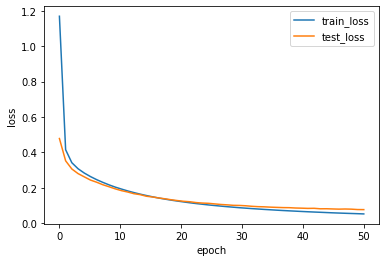

In [9]:
x = np.linspace(0,len(train_loss),len(train_loss))
plt.plot(x,train_loss,label="train_loss",linewidth=1.5)
plt.plot(x,test_loss,label="test_loss",linewidth=1.5)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()